<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png'>

In [1]:
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [28]:
(X_train, _), (X_test, y_test) = mnist.load_data()

In [29]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


X_train /= 255.0
X_test /= 255.0

In [30]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
channels = 1

In [31]:
X_train = X_train.reshape(X_train.shape[0], img_width, img_height, channels)
X_test = X_test.reshape(X_test.shape[0], img_width, img_height, channels)

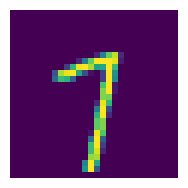

In [32]:
plt.figure(1)
plt.subplot(221)
plt.axis('off')
plt.imshow(X_train[42][:, :, 0]);

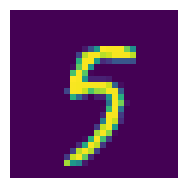

In [33]:
plt.figure(1)
plt.subplot(221)
plt.axis('off')
plt.imshow(X_train[420][:, :, 0]);

In [34]:
X_train.shape

(60000, 28, 28, 1)

In [10]:
latent_dim = 2

In [11]:
input_shape = (img_width, img_height, channels)

In [12]:
# encoder part
input_img = Input(shape=input_shape)
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

In [13]:
# latent dim part (central)

z_mu = Dense(latent_dim)(x)
z_sigma = Dense(latent_dim)(x)

def sample_z(args):
  mu, sigma = args
  eps = K.random_normal(shape=(K.shape(mu)[0], K.int_shape(mu)[1]))
  return mu + K.exp(sigma / 2) * eps

z = Lambda(sample_z, output_shape=(latent_dim,))([z_mu, z_sigma])

In [14]:
# combine them to encoder
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')

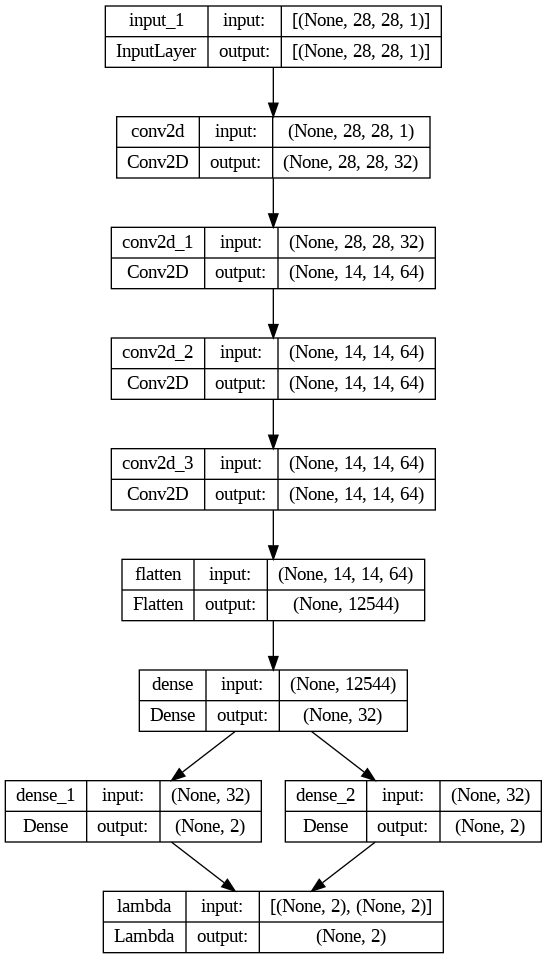

In [15]:
keras.utils.plot_model(encoder, show_shapes=True)

In [16]:
conv_shape

(None, 14, 14, 64)

In [17]:
# decoder
decoder_input = Input(shape=(latent_dim, ))

x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
output = Conv2DTranspose(channels, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, output)

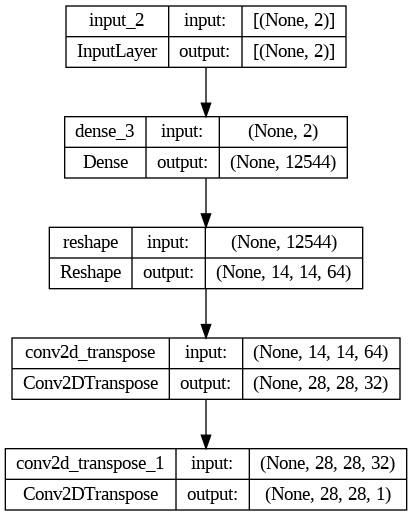

In [18]:
keras.utils.plot_model(decoder, show_shapes=True)

In [19]:
z_decoded = decoder(z)
z_decoded

<tf.Tensor 'model/conv2d_transpose_1/Sigmoid:0' shape=(?, 28, 28, 1) dtype=float32>

Loss

In [20]:
class LossLayer(keras.layers.Layer):
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
    return K.mean(recon_loss + kl_loss)

  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x

In [21]:
y = LossLayer()([input_img, z_decoded])
y

<tf.Tensor 'loss_layer/loss_layer/Identity:0' shape=(?, 28, 28, 1) dtype=float32>

In [22]:
vae_model = Model(input_img, y)

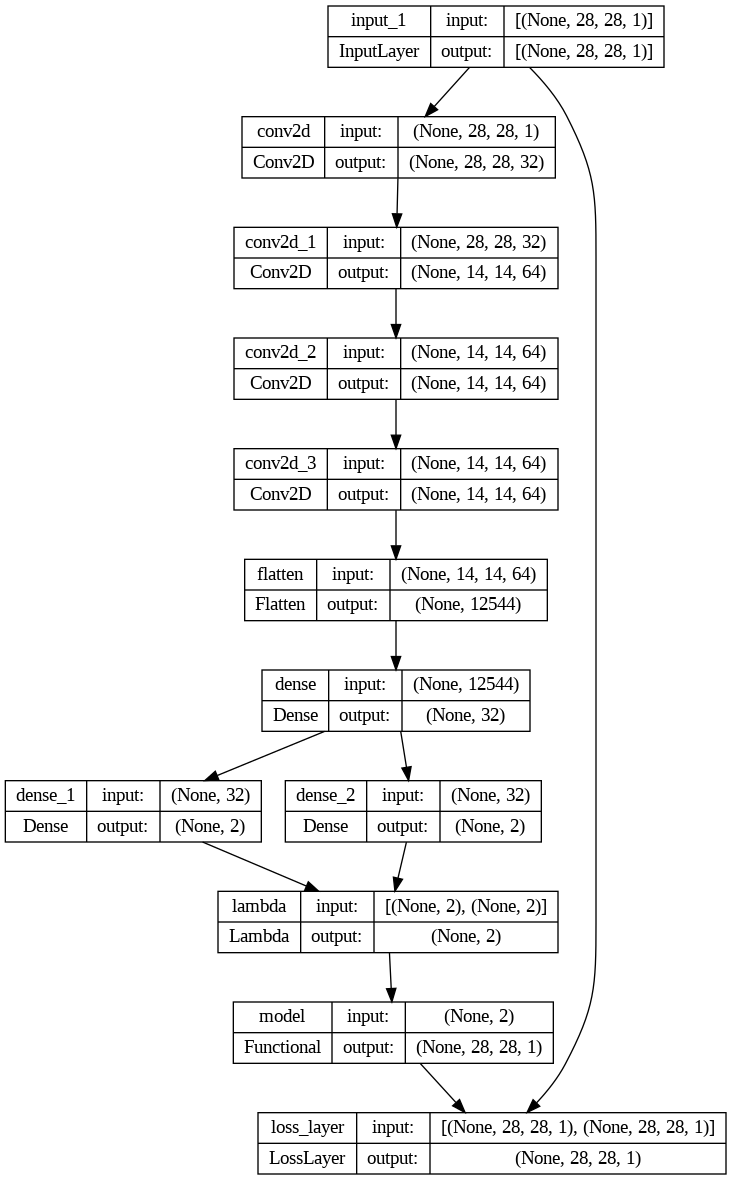

In [23]:
keras.utils.plot_model(vae_model, show_shapes=True)

In [24]:
vae_model.compile(
    optimizer='adam',
    loss=None
)

In [25]:
hist = vae_model.fit(
    X_train, None,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
47712/48000 [============================>.] - ETA: 0s - loss: 0.2239

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 [==============================] - 15s 317us/sample - loss: 0.2238 - val_loss: 0.2040
Epoch 2/10
48000/48000 [==============================] - 8s 167us/sample - loss: 0.1999 - val_loss: 0.1957
Epoch 3/10
48000/48000 [==============================] - 7s 155us/sample - loss: 0.1938 - val_loss: 0.1923
Epoch 4/10
48000/48000 [==============================] - 8s 167us/sample - loss: 0.1907 - val_loss: 0.1897
Epoch 5/10
48000/48000 [==============================] - 8s 168us/sample - loss: 0.1887 - val_loss: 0.1879
Epoch 6/10
48000/48000 [==============================] - 8s 157us/sample - loss: 0.1871 - val_loss: 0.1865
Epoch 7/10
48000/48000 [==============================] - 8s 168us/sample - loss: 0.1858 - val_loss: 0.1858
Epoch 8/10
48000/48000 [==============================] - 8s 167us/sample - loss: 0.1849 - val_loss: 0.1855
Epoch 9/10
48000/48000 [==============================] - 8s 159us/sample - loss: 0.1840 - val_loss: 0.1847
Epoch 10/10
48000/48000 [=============

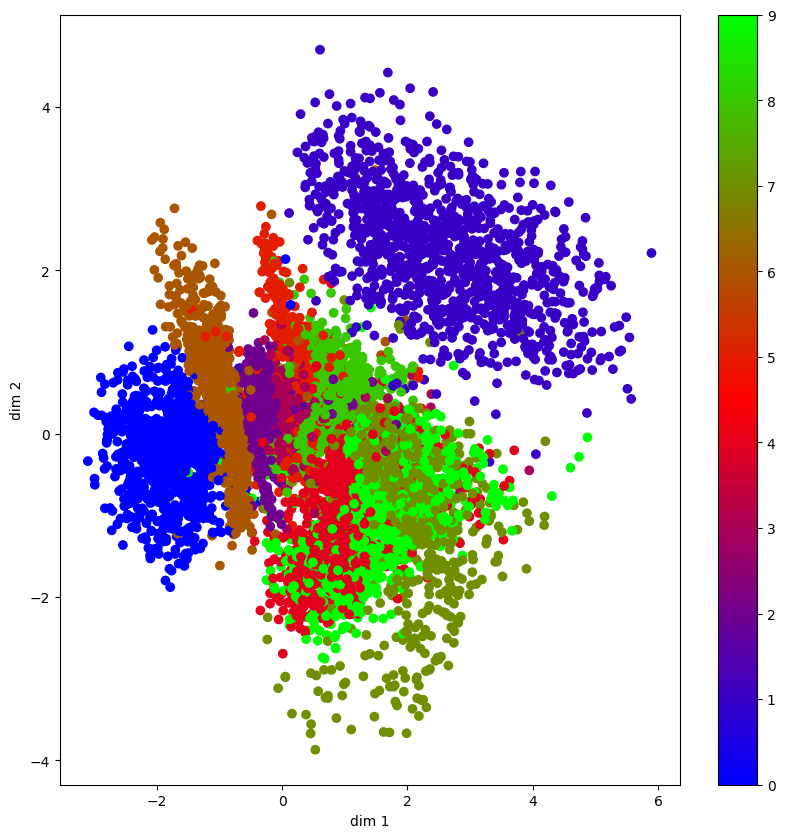

In [37]:
mu, _, _ = encoder.predict(X_test)
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


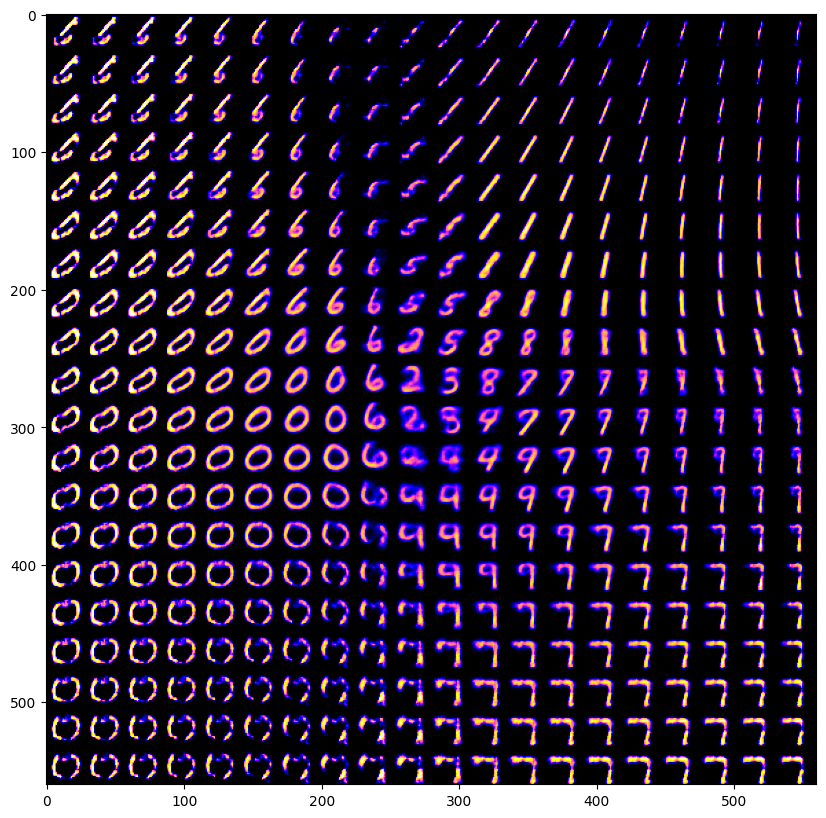

In [39]:
n = 20  # generate 15x15 digits
figure = np.zeros((img_width * n, img_height * n, channels))

#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()

In [41]:
pred = vae_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


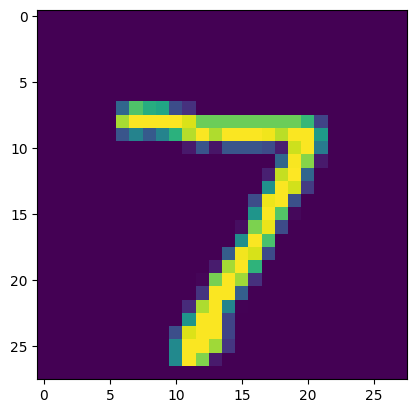

In [44]:
plt.imshow(pred[0])

<img src='https://media1.tenor.com/m/5RMWjetS9qcAAAAd/moist-critical.gif'>
<img src='https://media1.tenor.com/m/_rg-PfpMwqQAAAAC/penguinz0-pogchamp.gif'>
<img src='https://media1.tenor.com/m/j3V1aQSmiQUAAAAd/charlie-woooo-yeah-baby.gif'>
<img src='https://media1.tenor.com/m/m-y4URytgmwAAAAC/moistcritikal-moist.gif'>
<img src='https://media1.tenor.com/m/c87hdCQ2jTIAAAAd/wooooooo-fade.gif'>